<a href="https://colab.research.google.com/github/beaubakken/AOI/blob/master/Copy_of_RoundWorms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from torchvision import models, transforms, datasets
import torch.optim as optim
import torch
import torch.nn as nn
import os
from __future__ import print_function
from __future__ import division
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy

In [ ]:
alexnet = models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth


In [ ]:
for param in alexnet.parameters():
    param.requires_grad = False
# Makes sure we won't update the parameters of the feature extractor
# Parameters of newly constructed modules have requires_grad=True by default

In [ ]:
alexnet.classifier[6] = nn.Linear(4096, 2)
# replace last layer to only predict 2 classes
# requires_grad=True by default

In [ ]:
params_to_update = alexnet.parameters()
print("Params to learn:")
params_to_update = []
for name,param in alexnet.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


In [ ]:
optimizer = optim.Adam(params_to_update, lr=0.0001)
criterion = nn.CrossEntropyLoss()

In [ ]:
data_transforms = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [ ]:
data_dir = 'drive/My Drive/Summer Exploration/Hardware Security/cracky'
model = alexnet
batch_size = 50 #50
num_epochs = 25 #5
feature_extract = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms) for x in ['train', 'val']}

# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):  
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    loss_log_train = []
    loss_log_val =[]

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                   
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                        

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            if phase == 'train':
                loss_log_train.append(epoch_loss)
            elif phase == 'val':
                loss_log_val.append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                best_acc = epoch_acc

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, loss_log_train, loss_log_val

In [ ]:
model = model.to(device)
model_ft, hist, loss_log_train, loss_log_val = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

Epoch 0/24
----------
train Loss: 0.4946 Acc: 0.7734
val Loss: 0.3270 Acc: 0.9107

Epoch 1/24
----------
train Loss: 0.2669 Acc: 0.9202
val Loss: 0.2513 Acc: 0.9085

Epoch 2/24
----------
train Loss: 0.2189 Acc: 0.9319
val Loss: 0.2197 Acc: 0.9263

Epoch 3/24
----------
train Loss: 0.1900 Acc: 0.9375
val Loss: 0.1950 Acc: 0.9464

Epoch 4/24
----------
train Loss: 0.1721 Acc: 0.9515
val Loss: 0.1835 Acc: 0.9464

Epoch 5/24
----------
train Loss: 0.1567 Acc: 0.9515
val Loss: 0.1717 Acc: 0.9487

Epoch 6/24
----------
train Loss: 0.1462 Acc: 0.9559
val Loss: 0.1668 Acc: 0.9487

Epoch 7/24
----------
train Loss: 0.1360 Acc: 0.9604
val Loss: 0.1589 Acc: 0.9487

Epoch 8/24
----------
train Loss: 0.1264 Acc: 0.9621
val Loss: 0.1521 Acc: 0.9487

Epoch 9/24
----------
train Loss: 0.1219 Acc: 0.9648
val Loss: 0.1485 Acc: 0.9487

Epoch 10/24
----------
train Loss: 0.1174 Acc: 0.9665
val Loss: 0.1448 Acc: 0.9509

Epoch 11/24
----------
train Loss: 0.1157 Acc: 0.9609
val Loss: 0.1407 Acc: 0.9509

Ep

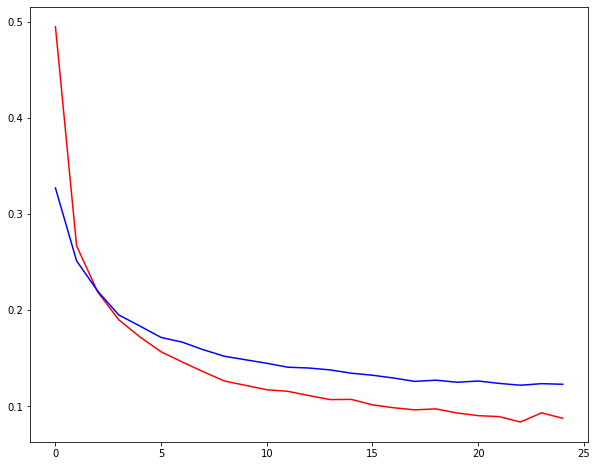

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(loss_log_train,'-r')
plt.plot(loss_log_val,'-b')